In [347]:
import pandas as pd
import numpy as np
import time
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [283]:
# waitlist and enrollment data
wl=pd.read_csv("onlywaitlists.csv")
wl

,Class,Data,BCCR1,BCCR2,BCCR3,BCCR4,CCCOMA3,CCCOMA4,CCCOMS3,CCCOMS4,...,GOSTAT2,GSCSCA3,GSCSCA4,GSFNEC4,GSUNDC2,GSUNDC3,PHBION1,OTHER,Total,Cap
0,TOTALS,NaN,132,131,106,89,9,10,103,108,...,0,62,109,5,35,42,0,NaN,NaN,NaN
1,CBMFW4761,enrollment,1,1,1,2,0,0,3,0,...,0,0,4,0,0,0,0,14.0,48.0,50.0
2,CBMFW4761,waitlist,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,NaN
3,COMSE6111,enrollment,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.0,75.0
4,COMSE6111,waitlist,0,0,0,3,0,0,5,12,...,0,2,5,0,0,0,0,5.0,172.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,CSEEW4840,waitlist,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0.0,46.0,NaN
83,CSORW4231,enrollment,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,200.0
84,CSORW4231,waitlist,0,0,7,3,2,0,5,4,...,0,6,7,0,0,0,0,23.0,193.0,NaN
85,ENGIE1006,enrollment,7,9,1,2,0,0,0,1,...,0,0,0,1,3,2,0,22.0,184.0,200.0


In [284]:
# data on what each of the group names mean
st=pd.read_csv( "students.csv")
st

,Program,Program_Name,Degree,Cert_Type,School,Department,Bill_Program_Flag,Interdisciplinary_Flag,Graduation_Flag,Office_Name,Program_Status,Program_Status_Date,Data_Refresh_Date
0,CCCOMA,COMPUTER SCIENCE AND MATHEMATICS,AB,MAJOR,CC,COMS,Y,N,Y,Computer Science,A,12/17/2004 0:00,2/7/2023 5:08
1,CCCOMS,COMPUTER SCIENCE,AB,MAJOR,CC,COMS,Y,N,Y,Computer Science,A,10/1/1991 0:00,2/7/2023 5:08
2,CCCOST,COMPUTER SCIENCE AND STATISTICS,AB,MAJOR,CC,COMS,Y,N,Y,Computer Science,A,9/11/2013 0:00,2/7/2023 5:08
3,CCDTSC,DATA SCIENCE ...,AB,MAJOR,CC,COMS,Y,N,Y,Computer Science,A,9/14/2016 0:00,2/7/2023 5:08
4,CCINFS,INFORMATION SCIENCES,AB,MAJOR,CC,COMS,Y,N,Y,Computer Science,A,6/10/2008 0:00,2/7/2023 5:08
5,CMCOMS,COMPUTER SCIENCE,AB,PREMED CONCN,CC,COMS,Y,N,Y,Computer Science,A,2/28/1997 0:00,2/7/2023 5:08
6,CNCOMS,COMPUTER SCIENCE,AB,CONCENTRATN,CC,COMS,Y,N,Y,Computer Science,A,10/1/1991 0:00,2/7/2023 5:08
7,CS/MBA,DUAL MS/MBA: COMPUTER SCIENCE AND BUSINESS,MS,DEGREE,EP,COMS,Y,N,Y,Computer Science,I,5/6/2000 0:00,2/7/2023 5:08
8,EACSIS,Information Systems,CPF,NON-DEGREE,EP,COMS,Y,N,N,Computer Science,A,5/13/1999 0:00,2/7/2023 5:08
9,EACSIT,Intelligent Systems,CPF,NON-DEGREE,EP,COMS,Y,N,N,Computer Science,A,6/28/1999 0:00,2/7/2023 5:08


In [294]:
# sum together enrollment and waitlist data
wl_data=wl.groupby(['Class']).sum().reset_index()
# dtop the row the totals waitlist number per class
wl_data=wl_data.drop(43)
print(wl_data["Cap"])
# drop excess column/rows, transpose to get groups as rows
wl_tr=wl_data.drop(['Class'], axis=1).transpose()
wl_tr=wl_tr.drop(["OTHER", "Total", "Cap"], axis=0)
# compute the total number of waitlists per group
wl_tr["total waitlists"]=wl_tr.sum(axis=1)
# total number of students in each group
wl_tr["total students"]=wl.iloc[0]

# compute the ratio betweem waitlists and total students
# this ratio can be interpeted as the average number of waitlists joined by students in this group
wl_tr["ratio"]=wl_tr["total waitlists"]/wl_tr["total students"]
# divide the number of waitlists per each course by the total number of waitlists
# this can be interpreted as the probability that a student in this group would join the waitlist for this particular class
wl_final=wl_tr[range(0,43)].div(wl_tr["total waitlists"], axis=0)
# bring back the previous columns, fill in naN values with 0
wl_final['waitlist']=wl_tr["total waitlists"]
wl_final['students']=wl_tr["total students"]
wl_final['ratio']=wl_tr["ratio"]
wl_final=wl_final.fillna(0)
# get rid of rows with no students 
wl_final = wl_final[wl_final["students"] > 2]
wl_final

0      50.0
1      75.0
2      30.0
3      30.0
4      35.0
5      30.0
6      20.0
7      25.0
8     490.0
9     796.0
10    160.0
11     50.0
12     60.0
13    500.0
14    398.0
15    360.0
16    300.0
17    598.0
18    120.0
19    160.0
20     75.0
21     75.0
22    398.0
23     45.0
24     40.0
25     69.0
26     60.0
27     40.0
28    328.0
29    299.0
30    160.0
31    100.0
32    147.0
33    220.0
34     60.0
35    630.0
36     30.0
37    280.0
38    100.0
39    170.0
40    110.0
41    200.0
42    200.0
Name: Cap, dtype: float64


/var/folders/y1/fzq6mttx6fb2fs_14z8crtcm0000gn/T/ipykernel_1197/1038287047.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wl_data=wl.groupby(['Class']).sum().reset_index()


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,waitlist,students,ratio
BCCR1,0.005682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.357955,...,0.000000,0.005682,0.000000,0.0,0.000000,0.000000,0.039773,176.0,132,1.333333
BCCR2,0.004167,0.000000,0.000000,0.004167,0.000000,0.000000,0.000000,0.0,0.000000,0.058333,...,0.000000,0.100000,0.000000,0.0,0.000000,0.000000,0.037500,240.0,131,1.832061
BCCR3,0.004587,0.000000,0.004587,0.032110,0.000000,0.000000,0.000000,0.0,0.000000,0.059633,...,0.000000,0.055046,0.022936,0.0,0.000000,0.032110,0.004587,218.0,106,2.056604
BCCR4,0.012048,0.018072,0.012048,0.024096,0.000000,0.006024,0.000000,0.0,0.018072,0.024096,...,0.000000,0.006024,0.018072,0.0,0.000000,0.018072,0.012048,166.0,89,1.865169
CCCOMA3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.076923,0.000000,0.0,0.000000,0.153846,0.000000,13.0,9,1.444444
CCCOMA4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.263158,0.000000,0.0,0.000000,0.000000,0.000000,19.0,10,1.900000
CCCOMS3,0.011070,0.018450,0.000000,0.003690,0.000000,0.003690,0.003690,0.0,0.025830,0.000000,...,0.000000,0.051661,0.029520,0.0,0.000000,0.018450,0.000000,271.0,103,2.631068
CCCOMS4,0.000000,0.054299,0.004525,0.022624,0.000000,0.004525,0.000000,0.0,0.049774,0.000000,...,0.000000,0.018100,0.036199,0.0,0.004525,0.018100,0.004525,221.0,108,2.046296
CCFNEC3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.052632,...,0.000000,0.052632,0.000000,0.0,0.000000,0.052632,0.052632,19.0,11,1.727273
CCUNDC1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.231343,...,0.000000,0.018657,0.000000,0.0,0.000000,0.007463,0.037313,268.0,188,1.425532


In [295]:
# samples a normal distribution
# need to figure out standard deviation--> could ask for this data? or just use a random number like 1
# sets any negative values to 0
def sample_class_num(mean, N):
    sample=np.round(np.random.poisson(mean, N))
    sample[sample<0]=0
    return sample

# randomly chooses courses according to the distribution
def course_ranking(class_num, course_prob):
    if(np.all(course_prob == 0)):
        print("all 0")
        return np.zeros(class_num)
    return np.random.choice(43,min(class_num, np.count_nonzero(course_prob)),p=course_prob, replace=False)

# for a certain group compute a sample of course rankings
def sample_course_ranking(group):
    cr=wl_final.loc[group]
    class_num=sample_class_num(cr.ratio, int(cr.students)).astype(int)
    vec=cr[range(0,43)]
    rank=[course_ranking(x, vec) for x in class_num]
    return rank

# rank = [[12,15], [12], [13]...] 


In [296]:
sample_class_num(4,10)

array([4, 4, 4, 2, 3, 4, 3, 1, 4, 4])

In [297]:

rank=sample_course_ranking("GSUNDC3")
rank

[array([35, 17]),
 array([28]),
 array([16, 29, 37, 13]),
 array([37]),
 array([9]),
 array([14, 13]),
 array([12, 15]),
 array([14, 37]),
 array([16]),
 array([15]),
 array([13]),
 array([], dtype=int64),
 array([13, 15,  9, 28]),
 array([14, 17]),
 array([13]),
 array([29]),
 array([], dtype=int64),
 array([14]),
 array([15, 37, 13]),
 array([13, 16, 37]),
 array([13]),
 array([17, 16]),
 array([37]),
 array([], dtype=int64),
 array([28, 14,  9, 12, 15]),
 array([], dtype=int64),
 array([17]),
 array([16, 42]),
 array([], dtype=int64),
 array([28, 13]),
 array([], dtype=int64),
 array([13, 14, 28]),
 array([22, 14]),
 array([37]),
 array([], dtype=int64),
 array([19, 33, 12]),
 array([ 9, 15, 19]),
 array([13, 15]),
 array([35, 14]),
 array([37, 16, 14]),
 array([14, 15]),
 array([], dtype=int64)]

In [298]:
## create ranks here
## i.e. [1,2,3]
## schedule with [1] will have score 3
## schedule with [2] will have score 2
## schedule with [3] will have score 1
## utility is sum of scores, sort bundles by highest utility


def generate_demand_set(arr, max_bundle_size):
    possible_bundles = []
    for i in range(len(arr)):
        for j in range(i + 1, len(arr) + 1):
            bundle = arr[i:j]
            possible_bundles.append((sum(bundle), bundle))
    #put in order of utility
    possible_bundles.sort(key=lambda x: (x[0], len(x[1])), reverse=True)
    #get rid of bundles that are too large
    final_possible_bundles = [x[1] for x in possible_bundles if len(x) <= max_bundle_size]
    return final_possible_bundles



In [299]:
rank=sample_course_ranking("GSUNDC3")

all_demand_sets = []
for student in rank:
    demand_set = generate_demand_set(student, 3)
    all_demand_sets.append(demand_set)

all_demand_sets



[[array([35,  9, 13, 14]),
  array([35,  9, 13]),
  array([35,  9]),
  array([ 9, 13, 14]),
  array([35]),
  array([13, 14]),
  array([ 9, 13]),
  array([14]),
  array([13]),
  array([9])],
 [array([28])],
 [array([15,  9]), array([15]), array([9])],
 [array([16, 15, 13]),
  array([16, 15]),
  array([15, 13]),
  array([16]),
  array([15]),
  array([13])],
 [array([37, 15]), array([37]), array([15])],
 [array([13, 14, 16,  9]),
  array([13, 14, 16]),
  array([14, 16,  9]),
  array([14, 16]),
  array([13, 14]),
  array([16,  9]),
  array([16]),
  array([14]),
  array([13]),
  array([9])],
 [array([ 9, 35]), array([35]), array([9])],
 [],
 [array([13, 15]), array([15]), array([13])],
 [array([14])],
 [],
 [array([13, 42]), array([42]), array([13])],
 [array([13, 35]), array([35]), array([13])],
 [array([14])],
 [array([17,  9]), array([17]), array([9])],
 [array([13, 16, 37, 14,  9, 28, 12]),
  array([13, 16, 37, 14,  9, 28]),
  array([16, 37, 14,  9, 28, 12]),
  array([16, 37, 14,  9, 28

In [300]:
rank=sample_course_ranking("GSUNDC3")
print(rank)
def get_all_demand_set(rank,max_bundle_size=3):
    all_demand_sets = []
    for student in rank:
        demand_set = generate_demand_set(student, max_bundle_size)
        all_demand_sets.append(demand_set)

    return all_demand_sets

[array([13]), array([14,  9]), array([15, 28]), array([9]), array([14, 15, 12, 16]), array([15, 37]), array([22]), array([], dtype=int64), array([42, 28]), array([13]), array([], dtype=int64), array([28, 16, 13]), array([14, 13, 12]), array([16, 13]), array([19]), array([14, 15]), array([28, 13]), array([ 9, 16, 37]), array([14,  9, 13, 22]), array([42, 13,  9, 16, 14]), array([29, 14]), array([42, 14]), array([ 9, 14, 33]), array([37]), array([ 9, 42, 14, 37]), array([], dtype=int64), array([15]), array([], dtype=int64), array([13, 15]), array([13, 37]), array([35]), array([15]), array([13,  9, 37]), array([15]), array([28, 29]), array([13,  9, 37]), array([15]), array([37]), array([], dtype=int64), array([15, 13]), array([], dtype=int64), array([12, 13])]


In [301]:
wl.fillna(0, inplace=True)
wl_data2=wl.groupby(['Class']).sum().reset_index()
wl_data2

/var/folders/y1/fzq6mttx6fb2fs_14z8crtcm0000gn/T/ipykernel_1197/3397330978.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wl_data2=wl.groupby(['Class']).sum().reset_index()


,Class,BCCR1,BCCR2,BCCR3,BCCR4,CCCOMA3,CCCOMA4,CCCOMS3,CCCOMS4,CCFNEC3,...,GOSTAT2,GSCSCA3,GSCSCA4,GSFNEC4,GSUNDC2,GSUNDC3,PHBION1,OTHER,Total,Cap
0,CBMFW4761,1,1,1,2,0,0,3,0,0,...,0,0,4,0,0,0,0,14.0,48.0,50.0
1,COMSE6111,0,0,0,3,0,0,5,12,0,...,0,2,5,0,0,0,0,5.0,173.0,75.0
2,COMSE6156,0,0,1,2,0,0,0,1,0,...,0,0,3,0,0,0,0,0.0,19.0,30.0
3,COMSE6178,0,1,7,4,0,0,1,5,0,...,0,0,2,0,0,0,0,8.0,71.0,30.0
4,COMSE6261,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,2.0,12.0,35.0
5,COMSE6424,0,0,0,1,0,0,1,1,0,...,0,0,2,0,0,0,0,0.0,38.0,30.0
6,COMSE6732,0,0,0,0,0,0,1,0,0,...,0,0,2,0,0,0,0,0.0,21.0,20.0
7,COMSE6915,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,25.0
8,COMSE6998,0,0,0,3,0,0,7,11,0,...,0,2,6,0,0,0,0,8.0,235.0,490.0
9,COMSW1004,63,14,13,4,0,0,0,0,1,...,0,0,0,0,10,8,0,34.0,267.0,796.0


In [302]:
# Creates a dataframe of 1's and 0's for the specified group
# based on the demand set that provides the highest 
# utility (i.e. the first set  returned from get_all_demand_set(rank, bundle_size) 

# this isnt used 
def allocate_group(group_demand_sets):
    max_demand_set=[]
    for i,demand in enumerate(group_demand_sets):
        if len(demand) != 0:
            max_demand_set.append(demand[0])
            
    rows = len(wl_data2)
    columns = len(max_demand_set)
    matrix_of_zeros = np.zeros((rows, columns))

    df_allocation=pd.DataFrame(matrix_of_zeros)
    df_allocation['Class']=wl_data2['Class']
    last_column = df_allocation.columns[-1]

    # Move the last column to the first position
    df_allocation = df_allocation[[last_column] + [col for col in df_allocation.columns if col != last_column]]

    for i,classes in enumerate(max_demand_set):
        j=0
        while j <len(classes):
            df_allocation.iloc[classes[j],i]=1
            j+=1
            
            
    return df_allocation

In [303]:
def one_hot_encode(input_list):
    encoded_vector = np.zeros(43)
    encoded_vector[input_list] = 1
    return encoded_vector.tolist()

def demand_set_to_one_hot(all_demand_set):
	one_hot_demand_sets = []
	for student_ds in all_demand_set: 
		student_one_hot_ds = []
		for bundle in student_ds: 
			one_hot = one_hot_encode(bundle)
			student_one_hot_ds.append(one_hot)
		one_hot_demand_sets.append(student_one_hot_ds)
	return one_hot_demand_sets

def one_hot_to_demand_set(all_one_hot_demand_sets):
	demand_sets = []
	for student_one_hot_ds in all_one_hot_demand_sets:
		student_demand_set = []
		for bundle in student_one_hot_ds: 
			student_demand_set.append([index for index, value in enumerate(bundle) if value == 1])
		demand_sets.append(student_demand_set)
	return demand_sets 


In [304]:
def get_prices_for_each_allocation(prices, student_demand_set):
	price_for_each_demand_set = []
	for demand_set in student_demand_set: 
		prices_np = np.array(prices)
		demand_set_np = np.array(demand_set).T
		total_price = prices_np.dot(demand_set_np)
		price_for_each_demand_set.append(total_price[0])
	
	return price_for_each_demand_set


def budget_perterbations(initial_budget,prices, student_demand_set, epsilon): 
	# input: prices for each course & demand set for a student 
	# prices = [.2, .3, .1, .5] (ie, price of course at idx 0 is 0.3, price of course at idx 1 is 0.2)
	# student_demand_set = [[1,1,0,0], [1,0,0,0],[0,1,0,0]] where a student's most preferred bundle is [1,1,0,0] and they get classes 0 and 1
	# second preferred bundle is [1,0,0,0] where the student would get only class 0, etc. 

	# output: budget allocation for each student, ie if they spent 0.2 to 0.5 (noninclusive), they would want allocation [1,0,0,0]
	# if they spent 0.5 or more, they would want allocation [1,1,0,0]

	#idx 0 price is for the top ranked bundle 
	max_budget=initial_budget+epsilon 
	min_budget=initial_budget-epsilon
	if len(student_demand_set) == 0:
		return ([],[])
	
	price_for_each_demand_set = get_prices_for_each_allocation(prices,student_demand_set)
	allocations = []
	budget_intervals = []
	last_min_price = max(price_for_each_demand_set) + 1

	for i, bundle_price in enumerate(price_for_each_demand_set): 
		if bundle_price < last_min_price and bundle_price <= max_budget: 
			if len(student_demand_set[i]) == 0:
				continue
			allocations.append(student_demand_set[i])
			budget_intervals.append((max(bundle_price,min_budget), min(last_min_price,max_budget)))
			last_min_price = bundle_price
  #print("alloc: ", allocations)
# 	print("budget intervals: ", budget_intervals)
	
	return (allocations, budget_intervals)



In [305]:
def pad_arrays(allocations):
	max_len = len(max(allocations, key=len)) 
	for allocation in allocations: 
		while len(allocation) < max_len: 
			allocation.append(allocation[-1])
	return allocations

In [323]:
# step size and error 

def clearing_error_optimizer(a, c, p):
	n=len(a)
	m=len(c)
	ki=len(a[0])
	# Create a new model
	model = gp.Model("Clearing_Error_Minimization")

	# Decision variables
	# These are the dimensions of the decision variable array
	# array of binary decision variables with n rows and ki columns
	# z = model.addVars(m, lb=0.0, vtype=GRB.INTEGER, name="z")
	# x = model.addVars(n, ki, vtype=GRB.BINARY, name="x")

	# # Objective function: Minimize the l1-norm of vector z
	# model.setObjective(gp.quicksum(z[j] for j in range(m)), sense=GRB.MINIMIZE)

# clearing error variables
	z = model.addVars(m, vtype=GRB.INTEGER, name="z")
	y = model.addVar(name="y")
	x = model.addVars(n, ki, vtype=GRB.BINARY, name="x")


    # OBJECTIVE: minimize y, which will be equal to the 1-norm of z
	model.setObjective(y, sense=GRB.MINIMIZE)

    # Constraints

    #Set y == ||z||_1
	model.addGenConstrNorm(y, z, 1.0, "normconstr")
	# Constraints
	for j in range(m):
		if p[j]>0:
			model.addConstr(gp.quicksum(x[i, l] * a[i][l][j] for i in range(n) for l in range(ki)) == c[j] + z[j], f"clearing_error_positive_{j}")
		if p[j]==0:
			model.addConstr(gp.quicksum(x[i, l] * a[i][l][j] for i in range(n) for l in range(ki)) <= c[j] + z[j], f"clearing_error_nonnegative_{j}")
	
	for i in range(n):
		model.addConstr(gp.quicksum(x[i, l] for l in range(ki)) == 1, f"one_schedule_per_student_{i}")

	# Solve the model
	model.optimize()

	# Check optimization status
	if model.status == GRB.OPTIMAL:
		# Access the optimal solution
		optimal_x = model.getAttr("x", x)
		optimal_z = model.getAttr("x", z)
		optimal_obj = model.ObjVal
		# Print or use the optimal solution as needed
# 		print("Optimal x values:", optimal_x)
# 		print("Optimal z values:", optimal_z)
		return (optimal_x, optimal_z,optimal_obj)
	else:
# 		print(f"Optimization terminated with status {model.status}")
		# Check if the model is infeasible
		model.computeIIS()
		print("\nInfeasible constraints:")
		for c in model.getConstrs():
			if c.IISConstr:
				print(c.constrName)
		return (None, None)




In [324]:



# def budget_perterbations(initial_budget,prices,….
# 	max_budget=initial_budget+epsilon 
# 	min_budget=initial_budget-epsilon


# def get_budget_perterbations(initial_budgets,prices, one_hot_demand_set,epsilon):
# 	all_budget_perterbations = []
# 	all_budget_intervals = []
# 	for i in range(len(one_hot_demand_set)): 
#         student_demand_set=one_hot_demand_set[i]
# 		initial_budget=initial_budgets[i]
# 		allocations, budget_intervals = budget_perterbations(initial_budget, prices, student_demand_set, epsilon)


# def aceei(one_hot_demand_set,delta, epsilon, prices): 
# 	f = open("out2.txt", "w+")
# 	initial_budgets=levels
# 	for i in range(500): 


In [341]:
#example input
def show_classes_per_student(x,a, budgets): 
	student_classes = {}
	student_budgets={}
	for key, value in x.items(): 
		bundle = a[key[0]][key[1]]
		if value != 0: 
			if key[0] not in student_classes: 
				student_demand_set = []
				student_demand_set.append([index for index, value in enumerate(bundle) if value == 1])
				student_classes[key[0]] = student_demand_set
				budget = budgets[key[0]][key[1]]
				student_budgets[key[0]] = budget[0]

	return student_classes, student_budgets

def show_students_per_class(x, a):
	class_students = {}
	for key, value in x.items(): 
		if value == 0:
			continue
		bundle = a[key[0]][key[1]]
		for i, class_num in enumerate(bundle):
			if class_num == 1 and i not in class_students: 
				class_students[i] = [key[0]]
			elif class_num == 1: 
				class_students[i].append(key[0])
	return class_students

def get_budget_perterbations(initial_budgets,prices, one_hot_demand_set, epsilon):
	all_budget_perterbations = []
	all_budget_intervals = []
	for i in range(len(one_hot_demand_set)):
		student_demand_set=one_hot_demand_set[i]
		initial_budget=initial_budgets[i]
		allocations, budget_intervals = budget_perterbations(initial_budget, prices, student_demand_set, epsilon)
		if allocations != [] and budget_intervals != []:
			all_budget_perterbations.append(allocations)
			all_budget_intervals.append(budget_intervals)

	allocations = pad_arrays(all_budget_perterbations)
	budget_intervals = pad_arrays(all_budget_intervals)
	return allocations, budget_intervals

def pretty_print_output(x, prices,z,a,b, f):
	student_classes, student_budgets = show_classes_per_student(x,a,b)
	for key in student_classes: 
		f.write("student: "+str(key)+ " classes: "+str(student_classes[key]) +" budget: "+str(student_budgets[key])+ "\n")

	classes_per_student = show_students_per_class(x, a)
	for key in classes_per_student: 
		f.write("class: "+ str(key)+" students: "+ str(classes_per_student[key])+ "\n")
		f.write("class: "+ str(key)+" number of students allocated: "+ str(len(classes_per_student[key]))+ "\n")        
		f.write("class: " + str(key) + " capacity: " + str(len(classes_per_student[key])) + "\n")
	string_list = [str(float_value) for float_value in prices[0]]
	prices_string = ' '.join(string_list)
	f.write("prices: "+ prices_string+ "\n")
	string_list_z = [str(float_value) for float_value in z]
	prices_string_z = ' '.join(string_list_z)
	f.write("z: "+ prices_string_z+ "\n")

def aceei(one_hot_demand_set,delta, epsilon, prices): 
	error=[]
	f = open("out.txt", "w+")
	start_time = time.time()
	levels=np.array([])
	for i in range(len(wl_final)):
		ind=wl_final.index[i]
		stud=wl_final['students'][i]
		num=int(ind[len(ind)-1])
		if num==1:
			levels=np.append(levels, np.repeat(0.8,stud))
		if num==2:
			levels=np.append(levels, np.repeat(0.9,stud))
		if num==3:
			levels=np.append(levels, np.repeat(1.0,stud))
		if num==4:
			levels=np.append(levels, np.repeat(1.1,stud))

	initial_budgets=levels
	optimal_sol=100
	i=0
	while optimal_sol!=0:
		f.write("\n Epoch: " + str(i) + "\n")
		a, b = get_budget_perterbations(initial_budgets,prices, one_hot_demand_set, epsilon)
# 		print(np.array(a).shape, np.array(b).shape)
		newCap = (wl_data2["Cap"] / 2).astype(int)		
		c = newCap.transpose().tolist()[:-1]
		p = prices[0]
		x, z, optimal_sol = clearing_error_optimizer(a, c, p)
		pretty_print_output(x, prices, z.values(), a,b , f)
		prices = (np.array(prices) + np.array(list(z.values()))*delta).tolist()
		error.append(optimal_sol)
		i +=1
		if i >500:
			optimal_sol=0
			print("Terminated without converging")
	end_time = time.time()
	total_time=end_time-start_time
	f.close()
	return (prices, x,error)


In [342]:
def generate_full_student_dataset(): 
	complete_demand_set = [] 
	for class_name in wl_final.index:
		rank=sample_course_ranking(class_name)
		all_demand_set=get_all_demand_set(rank,3)
		filtered_demand_set = []
		for ds in all_demand_set:
			if len(ds) == 0:
				continue
			filtered_demand_set.append(ds)
			
		one_hot_demand_set = demand_set_to_one_hot(filtered_demand_set)
		complete_demand_set.extend(one_hot_demand_set)

	return complete_demand_set

In [343]:


one_hot_demand_set_2 = [[[1,1], [0,1], [1,0]], [[1,1], [0,1], [1,0]], [[1,1], [1,0],[0,1]], [[1,1], [1,0], [0,1]]]
one_hot_demand_set = generate_full_student_dataset()



In [344]:
start_time = time.time()
initial_prices = [[0] * 43]
# print(initial_prices, len(one_hot_demand_set))
delta=0.0006
epsilon =0.01
prices, x, error = aceei(one_hot_demand_set,0.0006,0.01,initial_prices)
end_time = time.time()
total_time=end_time-start_time
print(total_time)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2161 rows, 2162 columns and 7888 nonzeros
Model fingerprint: 0xdab0252f
Model has 1 general constraint
Variable types: 1 continuous, 2161 integer (2118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 2161 rows and 2162 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 1: 2151 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.151000000000e+03, best bound 2.151000000000e+03, gap 0.0000%
BH Optimal output 2151.0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M

In [350]:
delta=0.0006
epsilon =0.01

TypeError: 'int' object is not iterable

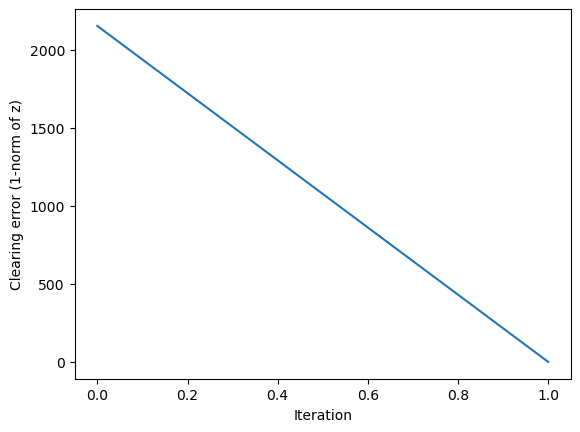

In [357]:
newCap = (wl_data2["Cap"] / 2).astype(int)		
c = newCap.transpose().tolist()[:-1]
K=len(one_hot_demand_set[0])

## Arrange the plot

#empirical
x_axis = np.array(range(0, len(error)))
plt.plot(x_axis, error, label="Clearing error")
plt.ylabel("Clearing error (1-norm of z)")
plt.xlabel("Iteration")

#theory bound
alpha = np.sqrt(min(2*K), len(c)* len(c)/2)
plt.axhline(alpha, color="r", label="Theory bound", linestyle="dashed")


plt.title(f"Clearing error for n={len(one_hot_demand_set)}, m={43}, k={K}, d={delta}, e={epsilon}")
plt.legend(loc="upper right")

plt.show()
